## Example to formulate base optimization and flexibility quantification

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math

![Flexibility Concept](flex_concept.jpg)

In [2]:
# Parameters
horizon = 24  # Time horizon, e.g., 24 hours
max_battery_power = 100  # Maximum power capacity of the battery
min_battery_power = 0  # Minimum power capacity of the battery
battery_efficiency = 0.9  # Efficiency of the battery
initial_soc = 50  # Initial State of Charge
max_soc = 100  # Maximum State of Charge
min_soc = 0  # Minimum State of Charge
np.random.seed(42)  # You can choose any number as the seed
energy_price = np.random.rand(horizon) * 100  # Example energy price

# Decision variables
charging_power = cp.Variable(horizon)
soc = cp.Variable(horizon)

In [3]:
# Initial SOC constraint
constraints = [soc[0] == initial_soc]

# SOC update rule and bounds
for t in range(1, horizon):
    constraints += [
        soc[t] == soc[t-1] + charging_power[t] * battery_efficiency,
        soc[t] <= max_soc,
        soc[t] >= min_soc
    ]

# Power capacity constraints
constraints += [
    charging_power <= max_battery_power,
    charging_power >= min_battery_power,
    soc[horizon-1] >= 80  # Set artificial terminal SOC requirement
]

# Objective function 
objective = cp.Minimize(cp.sum(cp.multiply(charging_power, energy_price)))

# Optimal control problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve(solver=cp.ECOS)

# Print the optimized battery power usage and SOC
print("Optimized Battery Power Usage:", charging_power.value)
print("State of Charge:", soc.value)

Optimized Battery Power Usage: [1.37195929e-11 4.79263715e-12 5.94751158e-12 7.00429612e-12
 2.66821401e-11 2.62039830e-11 3.01263252e-10 5.19274416e-12
 7.06413296e-12 6.19249289e-12 3.33333333e+01 4.79031340e-12
 5.45736299e-12 1.46870770e-11 1.54266675e-11 1.40063462e-11
 1.03654270e-11 7.81156713e-12 8.67996857e-12 8.53326644e-12
 6.82635199e-12 1.44257465e-11 4.13007158e-12 9.03947961e-12]
State of Charge: [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80.]


##### Note that ECOS and OSQP solvers are embedded free solvers. They may encounter numerical issues. Use Gurobi and Mosek if you have the licenses


## Now add flexibility envelope quantification 

#### Derive upper bound

In [4]:
# Create an exponentially decaying time series
time_series = np.array([math.exp(-i / horizon) for i in range(horizon)])

# Objective function for upper bound identification
objective_upper = cp.Minimize(- cp.sum(cp.multiply(time_series, charging_power)))

# Optimal control problem
problem_upper = cp.Problem(objective_upper, constraints)

# Solve the problem
problem_upper.solve(solver=cp.ECOS)

# Print the optimized battery power usage and SOC
print("Optimized Battery Power Usage:", charging_power.value)
print("State of Charge:", soc.value)

max_power_seriese = charging_power.value

Optimized Battery Power Usage: [1.00000000e+02 5.55555555e+01 2.09288130e-09 3.83349699e-09
 3.36283536e-09 2.92743698e-09 2.60581437e-09 2.37077560e-09
 2.19671683e-09 2.06635696e-09 1.96854170e-09 1.89608591e-09
 1.84438095e-09 1.81056234e-09 1.79300871e-09 1.79098589e-09
 1.80419768e-09 1.83177822e-09 1.86971829e-09 1.90500003e-09
 1.90659705e-09 1.84526772e-09 2.26874927e-09 4.59688764e-09]
State of Charge: [ 50.          99.99999995  99.99999996  99.99999996  99.99999996
  99.99999996  99.99999997  99.99999997  99.99999997  99.99999997
  99.99999997  99.99999998  99.99999998  99.99999998  99.99999998
  99.99999998  99.99999998  99.99999999  99.99999999  99.99999999
  99.99999999  99.99999999 100.         100.        ]


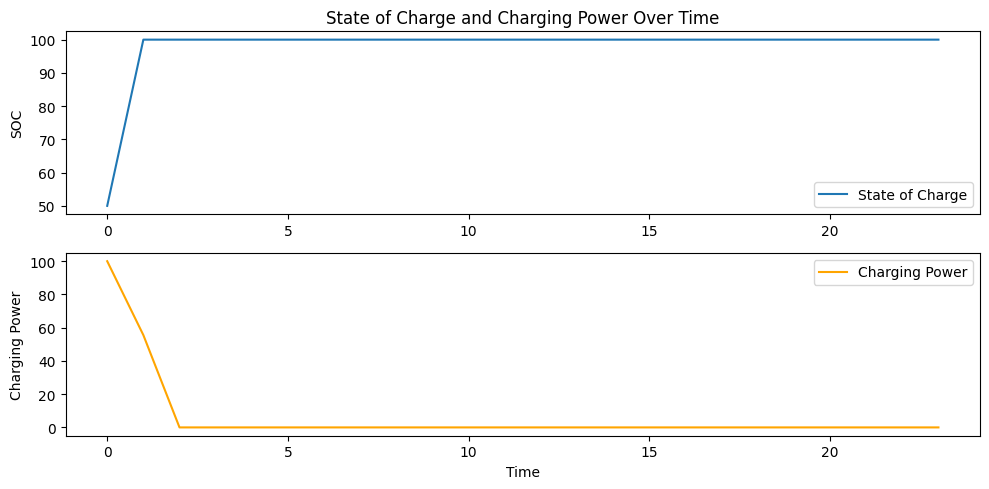

In [5]:
# Plot SOC values
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(soc.value, label='State of Charge')
plt.ylabel('SOC')
plt.title('State of Charge and Charging Power Over Time')
plt.legend()

# Plot Charging Power values
plt.subplot(2, 1, 2)
plt.plot(charging_power.value, label='Charging Power', color='orange')
plt.xlabel('Time')
plt.ylabel('Charging Power')
plt.legend()

plt.tight_layout()
plt.show()

#### Derive lower bound

In [6]:
# Create an exponentially decaying time series
time_series = np.array([math.exp(-i / horizon) for i in range(horizon)])

# Objective function for lower bound identification
objective_lower = cp.Minimize(cp.sum(cp.multiply(time_series, charging_power)))

# Optimal control problem
problem_lower = cp.Problem(objective_lower, constraints)

# Solve the problem
problem_lower.solve(solver=cp.ECOS)

# Print the optimized battery power usage and SOC
print("Optimized Battery Power Usage:", charging_power.value)
print("State of Charge:", soc.value)

min_power_seriese = charging_power.value

Optimized Battery Power Usage: [1.37621809e-10 1.79792238e-10 1.91499739e-10 2.03802428e-10
 2.16925210e-10 2.31046713e-10 2.46342937e-10 2.63012507e-10
 2.81294772e-10 3.01486492e-10 3.23959872e-10 3.49182869e-10
 3.77741584e-10 4.10365780e-10 4.47971182e-10 4.91787527e-10
 5.43833730e-10 6.08574186e-10 6.98012616e-10 8.44824273e-10
 1.12460201e-09 1.60690957e-09 9.70770428e-10 3.33333333e+01]
State of Charge: [50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         50.         50.00000001
 50.00000001 50.00000001 50.00000001 50.00000001 50.00000001 80.        ]


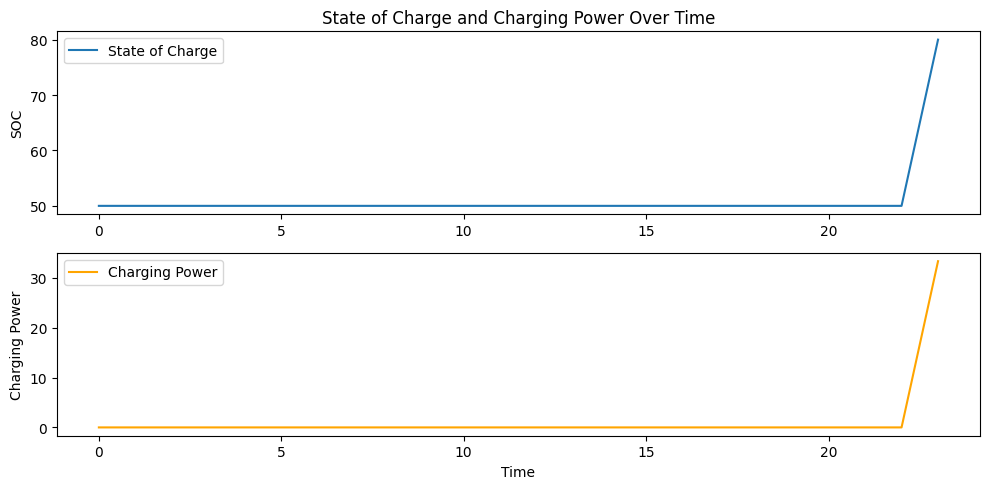

In [7]:
# Plot SOC values
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(soc.value, label='State of Charge')
plt.ylabel('SOC')
plt.title('State of Charge and Charging Power Over Time')
plt.legend()

# Plot Charging Power values
plt.subplot(2, 1, 2)
plt.plot(charging_power.value, label='Charging Power', color='orange')
plt.xlabel('Time')
plt.ylabel('Charging Power')
plt.legend()

plt.tight_layout()
plt.show()

#### Now cut the bounds

In [8]:
def energy_series(power):
    """
    Calculate energy bounds by summing power series.
    :type power: list
    :param power: list of power levels
    :return: a energy bound
    """

    energy = [i for i in power] 
    energy = np.cumsum(energy)
    return energy

def single_max_duration(power_level, upper_energy_bound, lower_energy_bound):
    """
    Given an power level, find the maximum sustained duration.
    :param power_level: give a specific active power level for building to track
    :param upper_energy_bound: upper energy bound in kWh
    :param lower_energy_bound: lower energy bound in kWh
    :return: maximum sustained duration
    """

    # Reconstruct an energy trajectory with new power level.
    energy = energy_series([power_level] * len(upper_energy_bound))

    # Earliest intersection between new power trajectory and the energy bounds.
    below_upper_bound = [int(i <= j) for i, j in zip(energy, upper_energy_bound)]
    above_lower_bound = [int(i >= j) for i, j in zip(energy, lower_energy_bound)]

    # Earliest intersection between new power trajectory and upper bound
    power_new_vs_emax = np.diff(below_upper_bound)
    # Find the smallest time stamp that the new energy bound is larger than upper_energy_bound
    if len(np.where(power_new_vs_emax == -1)[0]) > 0:
        max_quarter_max = np.where(power_new_vs_emax == -1)[0][0] + 1
    # If there is no change, it could mean input power level is out of range, or can be sustained larger than 24 hours
    elif energy[0] <= upper_energy_bound[0]:
        max_quarter_max = len(upper_energy_bound)
    else:
        max_quarter_max = 0
    max_quarter_max = max_quarter_max * below_upper_bound[0]

    # Earliest intersection between new power trajectory and lower bound
    power_new_vs_emin = np.diff(above_lower_bound)
    # Find the smallest time stamp that the new energy bound is smaller than lower_energy_bound
    if len(np.where(power_new_vs_emin == -1)[0]) > 0:
        max_quarter_min = np.where(power_new_vs_emin == -1)[0][0] + 1
    elif energy[0] >= lower_energy_bound[0]:
        max_quarter_min = len(lower_energy_bound)
    else:
        max_quarter_min = 0
    max_quarter_min = max_quarter_min * above_lower_bound[0]

    return np.minimum(np.sum(max_quarter_max), np.sum(max_quarter_min))


In [9]:
sustained_durations = []

for value in range(0, 101, 5):  # Ranging from 0 to 100 with a step of 5
    duration = single_max_duration(value, energy_series(max_power_seriese), energy_series(min_power_seriese))
    sustained_durations.append(duration)

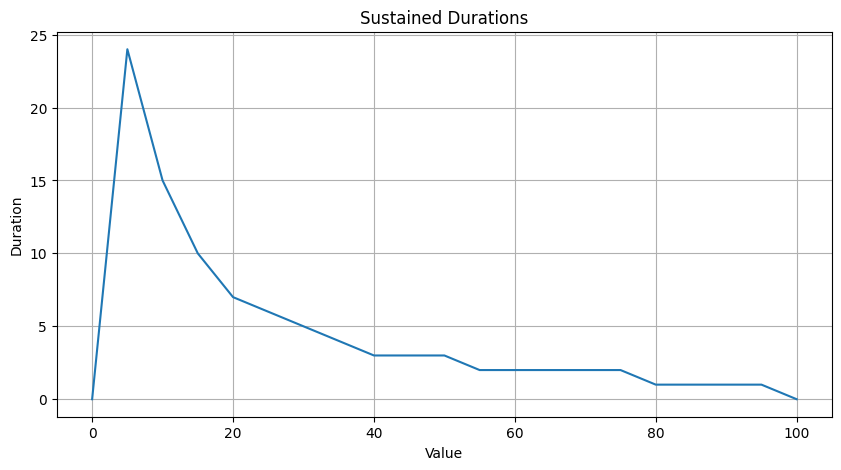

In [10]:
# Values used in the loop (0 to 100 with a step of 5)
x_values = range(0, 101, 5)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(x_values, sustained_durations) 
plt.title('Sustained Durations')
plt.xlabel('Value')
plt.ylabel('Duration')
plt.grid(True)
plt.show()